In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, classification_report
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Flatten, TimeDistributed, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from glob import glob
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, auc
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2

In [2]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [3]:
def build_model(input_shape=(299, 299, 9)):
    """
    Builds an improved Xception-based spatial feature extractor and a Bidirectional LSTM
    for temporal analysis with pooling layers and batch normalization.
    """
    print("Building improved model...")

    # Spatial Feature Extractor
    base_model = Xception(include_top=False, weights=None, input_shape=input_shape)

    # Use GlobalAveragePooling2D to aggregate the spatial features.
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    spatial_model = Model(inputs=base_model.input, outputs=x, name="spatial_model")

    # Temporal Analysis with LSTM (Improved)
    lstm_input = Input(shape=(None, 512), name="lstm_input")

    # Stack two Bidirectional LSTMs for better sequential feature extraction
    lstm_out = Bidirectional(LSTM(256, return_sequences=True, dropout=0.4, recurrent_dropout=0.2))(lstm_input)
    lstm_out = Bidirectional(LSTM(128, return_sequences=False, dropout=0.4))(lstm_out)
    lstm_out = BatchNormalization()(lstm_out)

    output = Dense(1, activation='sigmoid')(lstm_out)

    temporal_model = Model(inputs=lstm_input, outputs=output, name="temporal_model")

    print("Improved model built successfully.")
    return spatial_model, temporal_model


def train_model(spatial_model, temporal_model, x_train, y_train, x_test, y_test, epochs=100, batch_size=32):
    """Trains the model with improved training strategy."""
    print("Extracting features from Xception (Spatial Model)...")

    # Extract features from Xception
    x_train_features = spatial_model.predict(x_train)
    x_test_features = spatial_model.predict(x_test)

    # Reshape for LSTM
    x_train_features = np.expand_dims(x_train_features, axis=1)
    x_test_features = np.expand_dims(x_test_features, axis=1)

    # Compile the LSTM (Temporal Model)
    temporal_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    print("Training Improved Temporal Model (LSTM)...")

    # Callbacks
    model_checkpoint = ModelCheckpoint(
        filepath="best_model.h5",
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=False,
        mode="max",
        verbose=1
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)

    lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)

    # Train the LSTM Model
    history = temporal_model.fit(
        x_train_features, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test_features, y_test),
        callbacks=[model_checkpoint, early_stopping, lr_reducer]
    )

    print("Training completed.")

    # Predict on test set
    y_pred = temporal_model.predict(x_test_features)

    # Evaluate model
    plot_metrics(history, y_test, y_pred)


def plot_metrics(history, y_test, y_pred):
    """Plots training metrics, evaluation metrics, ROC curve, and precision-recall curve."""
    # Training Loss and Accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Training vs Validation Accuracy')
    plt.show()
    
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Training vs Validation Loss')
    plt.show()
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, (y_pred > 0.5).astype(int))
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

    # Compute ROC Curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    # Compute Precision-Recall Curve and AUC
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)
    
    # Plot Precision-Recall Curve
    plt.figure()
    plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()
    
    # Print evaluation metrics
    y_pred_binary = (y_pred > 0.5).astype(int)
    print(f'Accuracy Score: {accuracy_score(y_test, y_pred_binary):.4f}')
    print(f'ROC AUC Score: {roc_auc:.4f}')
    print(f'Recall Score: {recall_score(y_test, y_pred_binary):.4f}')
    print(f'Precision Score: {precision_score(y_test, y_pred_binary):.4f}')
    print(f'F1 Score: {f1_score(y_test, y_pred_binary):.4f}')
    print(f'PR AUC Score: {pr_auc:.4f}')
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred_binary))

In [5]:
import random

def load_precomputed_data(face_dir, flow_dir, edge_dir, label, condition_string, max_samples=15000):
    """Loads images in smaller batches to avoid memory overload."""
    x_data = []
    y_data = []
    count = 0

    print(f"\n🔄 Loading data from: {face_dir} (Label: {label}) - Filtering for '{condition_string}'")
    
    # Get list of relevant files
    face_files = [f for f in os.listdir(face_dir) if condition_string in f and f.endswith(".jpg")]

    if not face_files:
        print(f"⚠️ No '{condition_string}' images found in {face_dir}! Check filenames.")
        return np.array([]), np.array([])

    # Shuffle and limit to max_samples
    random.shuffle(face_files)
    face_files = face_files[:max_samples]

    batch_size = 1000  # Process in smaller batches
    for i in range(0, len(face_files), batch_size):
        batch_files = face_files[i:i+batch_size]

        batch_x = []
        for face_file in tqdm(batch_files, desc=f"Processing {face_dir} [{i}/{len(face_files)}]", unit="img"):
            base_name = os.path.splitext(face_file)[0].replace("_face", "")

            face_path = os.path.join(face_dir, face_file)
            flow_path = os.path.join(flow_dir, base_name + "_flow.jpg")
            edge_path = os.path.join(edge_dir, base_name + "_edges.jpg")

            if os.path.exists(face_path) and os.path.exists(flow_path) and os.path.exists(edge_path):
                try:
                    # Load images and resize
                    face_img = cv2.resize(cv2.imread(face_path), (299, 299))
                    flow_img = cv2.resize(cv2.imread(flow_path), (299, 299))
                    edge_img = cv2.resize(cv2.imread(edge_path), (299, 299))

                    # Normalize and convert to float32 to save memory
                    face_img = face_img.astype(np.float32) / 255.0
                    flow_img = flow_img.astype(np.float32) / 255.0
                    edge_img = edge_img.astype(np.float32) / 255.0

                    # Concatenate into a 9-channel image
                    combined_input = np.concatenate((face_img, flow_img, edge_img), axis=-1)

                    batch_x.append(combined_input)
                    y_data.append(label)

                except Exception as e:
                    print(f"⚠️ Error processing {face_file}: {e}")

        if batch_x:
            x_data.extend(batch_x)
        count += len(batch_x)

    if count == 0:
        print(f"⚠️ No valid samples found in {face_dir}. Please check file names and paths!\n")

    print(f"✅ Finished loading {count} images from {face_dir}.\n")
    return np.array(x_data, dtype=np.float32), np.array(y_data, dtype=np.int8)  # Convert to smaller dtype

# Load in smaller batches
print("🔄 Starting to load precomputed datasets...\n")
real_x, real_y = load_precomputed_data("E:/dataset/real", "E:/dataset/optical_flow", "E:/dataset/edges", label=0, condition_string="", max_samples=50000)
fake_x, fake_y = load_precomputed_data("E:/dataset/fake", "E:/dataset/optical_flow", "E:/dataset/edges", label=1, condition_string="", max_samples=50000)

# Ensure we loaded data
if real_x.size == 0 or fake_x.size == 0:
    print("❌ ERROR: No valid images loaded! Fix errors before continuing.")
    exit()

# **Use np.memmap to write data in chunks to avoid RAM overuse**
save_path = "E:/dataset/preprocessed_data_Exp3.npz"
print("💾 Saving preprocessed data in chunks to avoid memory issues...")

# Define shapes
total_samples = real_x.shape[0] + fake_x.shape[0]
image_shape = (299, 299, 9)

# Create a memory-mapped file
x_data_memmap = np.memmap(save_path.replace(".npz", "_x.dat"), dtype=np.float32, mode="w+", shape=(total_samples, *image_shape))
y_data_memmap = np.memmap(save_path.replace(".npz", "_y.dat"), dtype=np.int8, mode="w+", shape=(total_samples,))

# Write in chunks
x_data_memmap[:real_x.shape[0]] = real_x
x_data_memmap[real_x.shape[0]:] = fake_x
y_data_memmap[:real_y.shape[0]] = real_y
y_data_memmap[real_y.shape[0]:] = fake_y

# Flush to disk
del x_data_memmap, y_data_memmap  # Ensure it's saved before creating NPZ file

# Save final NPZ file with memory-efficient data
np.savez_compressed(save_path, x=np.memmap(save_path.replace(".npz", "_x.dat"), dtype=np.float32, mode="r", shape=(total_samples, *image_shape)), 
                                  y=np.memmap(save_path.replace(".npz", "_y.dat"), dtype=np.int8, mode="r", shape=(total_samples,)))

print("✅ Data saved successfully!")

🔄 Starting to load precomputed datasets...


🔄 Loading data from: E:/dataset/real (Label: 0) - Filtering for ''


Processing E:/dataset/real [49000/50000]: 100%|██████████| 1000/1000 [07:00<00:00,  2.38img/s]


✅ Finished loading 4864 images from E:/dataset/real.


🔄 Loading data from: E:/dataset/fake (Label: 1) - Filtering for ''


Processing E:/dataset/fake [9000/50000]:  59%|█████▉    | 592/1000 [04:09<02:51,  2.37img/s]


KeyboardInterrupt: 

In [4]:
# Load precomputed dataset
save_path = "E:/dataset/preprocessed_data_M004_Exp1.npz"
print(f"📂 Loading precomputed dataset from {save_path}...")
data = np.load(save_path)

# Extract x_data and y_data
x_data, y_data = data["x"], data["y"]
print(f"✅ Loaded dataset: {x_data.shape[0]} samples.")

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42, stratify=y_data)

# Verify shapes
print(f"📊 Train/Test Split:")
print(f"  x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"  x_test: {x_test.shape}, y_test: {y_test.shape}")

📂 Loading precomputed dataset from E:/dataset/preprocessed_data_M004_Exp1.npz...
✅ Loaded dataset: 2884 samples.
📊 Train/Test Split:
  x_train: (2307, 299, 299, 9), y_train: (2307,)
  x_test: (577, 299, 299, 9), y_test: (577,)


In [5]:
# if __name__ == "__main__":
#     real_faces = "E:/Research/real/Cropped_Faces"
#     fake_faces = "E:/Research/fake/Cropped_Faces"
    # real_data, fake_data = prepare_data(real_faces, "", fake_faces, "")
    
    # Build the Spatial and Temporal Models
spatial_model, temporal_model = build_model(input_shape=(299, 299, 9))

# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# y_test = y_test.astype('float32')
# y_test = y_test.astype('float32')

# spatial_model.summary()
temporal_model.summary()


Building improved model...


c:\Users\G713QM-\anaconda3\Lib\site-packages\keras\src\applications\xception.py:111: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 9 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Improved model built successfully.


Model: "temporal_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_input (InputLayer)         │ (None, None, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, None, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, None, 512)      │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,232,577 (8.52 MB)

 Trainable params: 2,232,065 (8.51 MB)

 Non-trainable params: 512 (2.00 KB)

Extracting features from Xception (Spatial Model)...
73/73 ━━━━━━━━━━━━━━━━━━━━ 248s 3s/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step
Training Improved Temporal Model (LSTM)...
Epoch 1/100
71/73 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5172 - loss: 0.6931
Epoch 1: val_accuracy improved from -inf to 0.50087, saving model to best_model.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.5165 - loss: 0.6931 - val_accuracy: 0.5009 - val_loss: 0.6931 - learning_rate: 1.0000e-04
Epoch 2/100
71/73 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5095 - loss: 0.6931
Epoch 2: val_accuracy did not improve from 0.50087
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5092 - loss: 0.6931 - val_accuracy: 0.5009 - val_loss: 0.6931 - learning_rate: 1.0000e-04
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5081 - loss: 0.6930
Epoch 3: val_accuracy did not improve from 0.50087
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5081 - loss: 0.6930 - val_accuracy: 0.5009 - val_loss: 0.6931 - learning_rate: 1.0000e-04
Epoch 4/100
72/73 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5361 - loss: 0.6929
Epoch 4: val_accuracy did not improve from 0.50087
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5363 - loss: 0.6929 - val_accuracy: 0.4991 - val_loss: 0.6931 - learning_rate: 1.0000e-04
Epoch 5/100
7

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5856 - loss: 0.6918 - val_accuracy: 0.8821 - val_loss: 0.6917 - learning_rate: 5.0000e-05
Epoch 12/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6205 - loss: 0.6910
Epoch 12: val_accuracy did not improve from 0.88215
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6205 - loss: 0.6910 - val_accuracy: 0.6118 - val_loss: 0.6913 - learning_rate: 5.0000e-05
Epoch 13/100
70/73 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6162 - loss: 0.6910
Epoch 13: val_accuracy did not improve from 0.88215
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6162 - loss: 0.6910 - val_accuracy: 0.5269 - val_loss: 0.6909 - learning_rate: 5.0000e-05
Epoch 14/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6269 - loss: 0.6906
Epoch 14: val_accuracy did not improve from 0.88215
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6270 - loss: 0.6906 - val_accuracy: 0.7296 - val_loss: 0.6904 - learning_rate: 5.0000e-05
Epoch 1

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6155 - loss: 0.6904 - val_accuracy: 0.9688 - val_loss: 0.6899 - learning_rate: 5.0000e-05
Epoch 16/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6460 - loss: 0.6898
Epoch 16: val_accuracy did not improve from 0.96880
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6457 - loss: 0.6898 - val_accuracy: 0.9636 - val_loss: 0.6893 - learning_rate: 5.0000e-05
Epoch 17/100
70/73 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6720 - loss: 0.6889
Epoch 17: val_accuracy did not improve from 0.96880
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6718 - loss: 0.6889 - val_accuracy: 0.8388 - val_loss: 0.6887 - learning_rate: 5.0000e-05
Epoch 18/100
72/73 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6623 - loss: 0.6886
Epoch 18: val_accuracy did not improve from 0.96880
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6624 - loss: 0.6886 - val_accuracy: 0.7695 - val_loss: 0.6878 - learning_rate: 5.0000e-05
Epoch 1

73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9499 - loss: 0.1520 - val_accuracy: 0.9757 - val_loss: 0.1351 - learning_rate: 5.0000e-05
Epoch 85/100
72/73 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9470 - loss: 0.1459
Epoch 85: val_accuracy did not improve from 0.97574
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9468 - loss: 0.1462 - val_accuracy: 0.9688 - val_loss: 0.1385 - learning_rate: 5.0000e-05
Epoch 86/100
72/73 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9389 - loss: 0.1572
Epoch 86: val_accuracy did not improve from 0.97574
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9389 - loss: 0.1573 - val_accuracy: 0.9428 - val_loss: 0.1684 - learning_rate: 5.0000e-05
Epoch 87/100
72/73 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9398 - loss: 0.1571
Epoch 87: val_accuracy did not improve from 0.97574
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9398 - loss: 0.1572 - val_accuracy: 0.9757 - val_loss: 0.1304 - learning_rate: 5.0000e-05
Epoch 8

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9545 - loss: 0.1335 - val_accuracy: 0.9775 - val_loss: 0.1132 - learning_rate: 5.0000e-05
Epoch 100/100
71/73 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9533 - loss: 0.1312
Epoch 100: val_accuracy did not improve from 0.97747
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9531 - loss: 0.1314 - val_accuracy: 0.9723 - val_loss: 0.1153 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 98.
Training completed.
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step


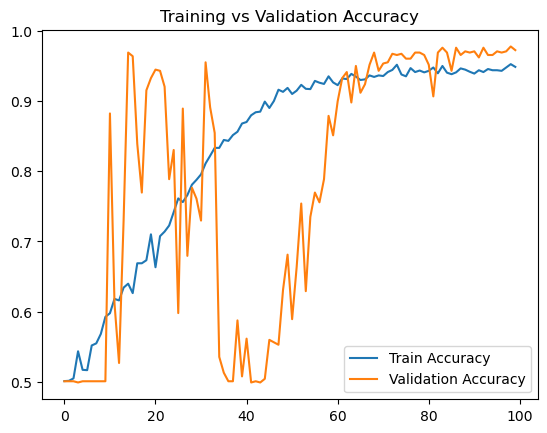

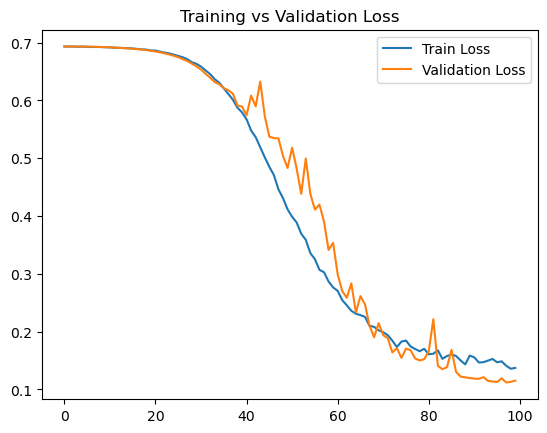

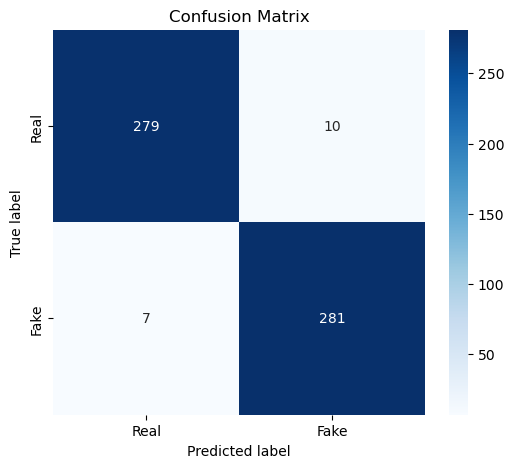

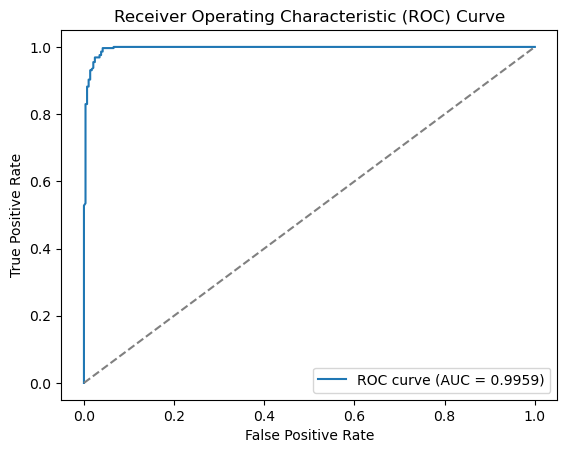

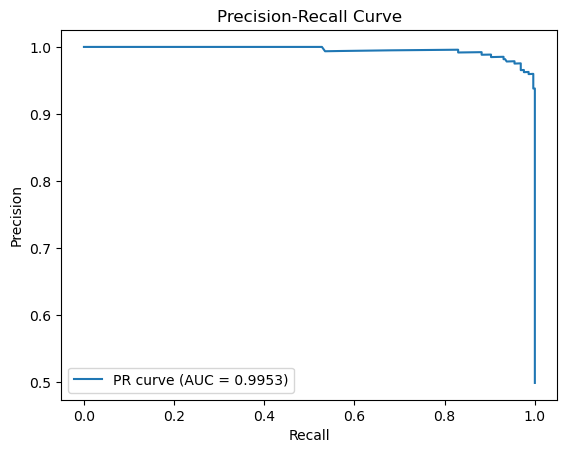

Accuracy Score: 0.9705
ROC AUC Score: 0.9959
Recall Score: 0.9757
Precision Score: 0.9656
F1 Score: 0.9706
PR AUC Score: 0.9953
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       289
           1       0.97      0.98      0.97       288

    accuracy                           0.97       577
   macro avg       0.97      0.97      0.97       577
weighted avg       0.97      0.97      0.97       577



In [6]:
# Train the Model
train_model(spatial_model, temporal_model, x_train, y_train, x_test, y_test, epochs=100, batch_size=32)